In [1]:
from autoencoders import *
from pdb_utils import *

import pickle
import numpy as np
import pandas as pd
import random

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from functools import partial
import sys

from Bio import PDB
import numpy as np
import os
import cv2

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
import time
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
def nice_time(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Runtime: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [3]:
with open("ProteinContactMapDict.pkl", "r") as f:
    proteinmatrixdict = pickle.load(f)

In [4]:
labels, features = list(proteinmatrixdict.keys()), list(proteinmatrixdict.values())
input_size = len(features[0])
print("Number of pdbs: %d"%len(features))
print("Input size: %d"%input_size)

Number of pdbs: 2765
Input size: 2016


In [22]:
print("\nLinear Autoencoder - 100 epochs")
s_time = time.time()
new_features, loss = LinearAutoencoder(features, input_size, 500, 100, learning_rate=0.0001)
end = time.time()
nice_time(s_time,end)


Linear Autoencoder - 100 epochs
Runtime: 00:16:39.20


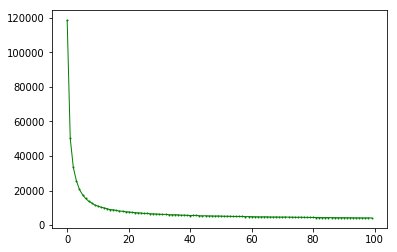

In [23]:
# LOSS GRAPH
fig, ax = plt.subplots()
ax.plot(range(0,len(loss)), loss, 'go-', linewidth=1, markersize=1)
fig.savefig("loss_figure.png")

In [7]:
with open('label_dict.pkl', 'rb') as f:
    label_dict = pickle.load(f)

In [8]:
def PdbClassifier(X,labels,label_dict,classifier,clf_level="family"):
    print("%s Level Classification")% clf_level.upper()
    # Encoding labels
    y = []
    for pdb in labels:
        if clf_level == "family":
            y.append(label_dict[pdb])
        elif clf_level == "superfamily":
            y.append(".".join(label_dict[pdb].split(".")[:3]))
        elif clf_level == "fold":
            y.append(".".join(label_dict[pdb].split(".")[:2]))
        elif clf_level == "class":
            y.append(label_dict[pdb].split(".")[0])
        else:
            print("Error: Not a valid classification level.")            
    uniques = list(set(y))
    print("Number of labels: %d"%len(uniques))
    group2id = dict(zip(uniques, range(len(uniques))))
    y = np.array(list(map(lambda x: group2id[x], y)))
    
    # Stratified Cross Validation
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    C = 1
    acc, prec, rec = 0,0,0
    s_time = time.time()
    for train_index, test_index in sss.split(X, y):
        print("\nStratified Cross Validation - %d"%C)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        print("Training...")
        # Fitting Random Forest Classification to the Training set
        classifier = classifier
        classifier.fit(X_train, y_train)
        
        # Print train/test accuracy
        y_pred_train = classifier.predict(X_train)
        print "Train accuracy: ",accuracy_score(y_train, y_pred_train)
        y_pred_test = classifier.predict(X_test)
        print "Test accuracy: ",accuracy_score(y_test, y_pred_test)
        
        acc+=accuracy_score(y_test, y_pred_test)
        prec+=precision_score(y_test, y_pred_test, average='weighted')
        rec+=recall_score(y_test, y_pred_test, average='weighted')
        C+=1
    end = time.time()
    nice_time(s_time,end)

    print "\naverage accuracy_score: ", acc/10
    print "average precision_score: ", prec/10
    print "average recall_score: ", rec/10

In [24]:
clf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)

In [20]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100,), learning_rate="adaptive", learning_rate_init=0.001)

In [25]:
X = np.array(new_features)
PdbClassifier(X,labels,label_dict,clf,clf_level="family")

FAMILY Level Classification
Number of labels: 200

Stratified Cross Validation - 1
Training...
Train accuracy:  0.9986437613019892
Test accuracy:  0.4430379746835443

Stratified Cross Validation - 2
Training...
Train accuracy:  0.9981916817359855
Test accuracy:  0.40325497287522605

Stratified Cross Validation - 3
Training...
Train accuracy:  0.9990958408679927
Test accuracy:  0.46112115732368897

Stratified Cross Validation - 4
Training...
Train accuracy:  0.9995479204339964
Test accuracy:  0.4321880650994575

Stratified Cross Validation - 5
Training...
Train accuracy:  0.9977396021699819
Test accuracy:  0.45569620253164556

Stratified Cross Validation - 6
Training...
Train accuracy:  0.9968354430379747
Test accuracy:  0.4267631103074141

Stratified Cross Validation - 7
Training...
Train accuracy:  0.9990958408679927
Test accuracy:  0.4321880650994575

Stratified Cross Validation - 8
Training...
Train accuracy:  0.9981916817359855
Test accuracy:  0.45750452079566006

Stratified Cross 

In [27]:
importances = clf.feature_importances_

In [28]:
importances

array([0.00163233, 0.00215058, 0.00089729, 0.0010511 , 0.00065601,
       0.00206863, 0.00172249, 0.0018574 , 0.00139424, 0.00089288,
       0.00064487, 0.00048507, 0.00192497, 0.00326723, 0.00157073,
       0.00020424, 0.00374625, 0.00077241, 0.00075884, 0.00215416,
       0.00046679, 0.00113753, 0.00142024, 0.00080123, 0.00744187,
       0.0037447 , 0.00086366, 0.00054775, 0.00065448, 0.00144142,
       0.00163726, 0.00061557, 0.00061182, 0.00122291, 0.00055214,
       0.00472689, 0.00033994, 0.0007913 , 0.00235415, 0.00498456,
       0.00082586, 0.00177026, 0.00093681, 0.00105326, 0.00072306,
       0.00281868, 0.00058672, 0.00051894, 0.00055451, 0.00207794,
       0.00092338, 0.00238309, 0.00110448, 0.00171362, 0.00086029,
       0.00142649, 0.00866942, 0.00054026, 0.00233652, 0.0074188 ,
       0.00152631, 0.00240142, 0.00181982, 0.00586994, 0.00200266,
       0.00070933, 0.00054068, 0.00190052, 0.00098985, 0.00030372,
       0.00053819, 0.00113157, 0.00289915, 0.00043034, 0.00088

In [19]:
X = np.array(new_features)
PdbClassifier(X,labels,label_dict,clf,clf_level="class")

CLASS Level Classification
Number of labels: 7

Stratified Cross Validation - 1
Training...
Train accuracy:  0.8969258589511754
Test accuracy:  0.6962025316455697

Stratified Cross Validation - 2
Training...
Train accuracy:  0.9055153707052441
Test accuracy:  0.7233273056057866

Stratified Cross Validation - 3
Training...
Train accuracy:  0.9082278481012658
Test accuracy:  0.7305605786618445

Stratified Cross Validation - 4
Training...
Train accuracy:  0.9367088607594937
Test accuracy:  0.7468354430379747

Stratified Cross Validation - 5
Training...
Train accuracy:  0.9751356238698011
Test accuracy:  0.7721518987341772

Stratified Cross Validation - 6
Training...
Train accuracy:  0.900994575045208
Test accuracy:  0.705244122965642

Stratified Cross Validation - 7
Training...
Train accuracy:  0.8571428571428571
Test accuracy:  0.7251356238698011

Stratified Cross Validation - 8
Training...
Train accuracy:  0.9159132007233273
Test accuracy:  0.7739602169981917

Stratified Cross Validatio